In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
data = pd.read_csv("/content/drive/Shareddrives/PD_Fall2021/Data/data.txt", sep=",", header=0)

In [ ]:
data.head()

,Unnamed: 0,date,int_rate,c_upb,loan_age,ori_ltv,ori_dti,state,nxt_state,HS,MDT_HPI,MDT_UMP,MDT_PPI,c_ltv,fico_cat
0,1,05/01/2009,4.875,157000.0,0,80,36.0,CR,CR,540,1.625,0.1,3.3,80.000000,720+
1,2,06/01/2009,4.875,157000.0,1,80,36.0,CR,CR,585,0.949,0.0,-1.6,79.132176,720+
2,3,07/01/2009,4.875,157000.0,2,80,36.0,CR,CR,594,-0.083,0.1,2.5,78.634021,720+
3,4,08/01/2009,4.875,157000.0,3,80,36.0,CR,CR,586,-1.041,0.2,-0.9,78.677339,720+
4,5,09/01/2009,4.875,157000.0,4,80,36.0,CR,CR,585,-1.040,0.2,1.1,79.224728,720+


In [ ]:
data.drop('Unnamed: 0', axis=1, inplace=True) ## remove unecessary column

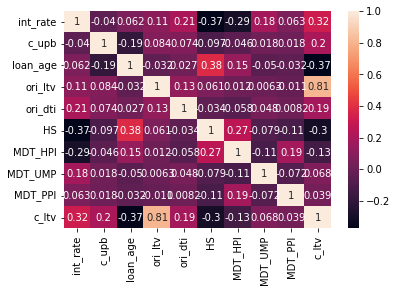

In [ ]:
## plot correlation heat map of all features
import seaborn as sn
import matplotlib.pyplot as plt
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
data.drop(['ori_ltv'], axis=1, inplace=True) ## remove this columns since it correlates strongly with cltv

In [ ]:
DL_data = data[data['state'] == 'DL'] ## pick loans with current state delinquent
DL_data['nxt_state'] = DL_data['nxt_state'].map({'DL':'ADL', 'CR': 'CR', 'DF': 'DF', 'PP': 'PP'}) ## map new catergory name for delinquency

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
DL_data['fico_cat'].unique() ## check to see nans or strange values

array(['720+', '690-720', '630-690', '<630'], dtype=object)

In [ ]:
## assign numerical values to categorical fico data 
DL_data['fico_cat']= DL_data['fico_cat'].map({'<630':'0', '630-690': '1', '690-720': '2', '720+': '3'})
DL_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,int_rate,c_upb,loan_age,ori_dti,state,nxt_state,HS,MDT_HPI,MDT_UMP,MDT_PPI,c_ltv,fico_cat
211,10/01/2015,4.750,66857.50,79,41.0,DL,CR,1058,0.099,0.1,-1.8,25.106084,3
1116,09/01/2011,4.375,292900.30,21,46.0,DL,CR,650,-1.757,-0.2,-2.6,75.665652,2
1295,05/01/2010,5.375,150872.23,7,34.0,DL,CR,583,0.665,-0.2,-1.3,95.287231,2
2846,03/01/2011,5.750,323743.17,26,22.0,DL,ADL,600,1.366,0.1,3.9,94.848299,3
2847,04/01/2011,5.750,323351.14,27,22.0,DL,ADL,554,1.530,-0.1,1.0,93.803524,3


In [ ]:
from sklearn import preprocessing 
DL_data = DL_data.sort_values(by='date')
DL_data['date'] = pd.to_datetime(DL_data['date'])
Y = DL_data['nxt_state']
X = preprocessing.scale(DL_data.drop(['nxt_state','state','date'], axis=1))
X_New=pd.DataFrame(data=X)

In [ ]:
X_New.columns = DL_data.drop(['nxt_state','state','date'], axis=1).columns
X_New.insert(10, "intercept", 1) 

In [ ]:
X_New.head()

,int_rate,c_upb,loan_age,ori_dti,HS,MDT_HPI,MDT_UMP,MDT_PPI,c_ltv,fico_cat,intercept
0,1.034016,-1.093519,-1.526383,-0.177038,1.92571,-0.418973,-0.428978,1.330298,0.388951,1.215268,1
1,0.727793,0.386774,-1.180095,0.875557,1.92571,-0.418973,-0.428978,1.330298,0.317415,1.215268,1
2,0.625718,1.263574,-1.110837,0.301414,1.92571,-0.418973,-0.428978,1.330298,0.305287,0.243921,1
3,1.442314,-0.207599,-1.353239,-0.942562,1.92571,-0.418973,-0.428978,1.330298,-0.933279,-0.727426,1
4,0.727793,0.175437,-1.214723,-0.368419,1.92571,-0.418973,-0.428978,1.330298,0.293388,0.243921,1


In [ ]:
Y1=list(Y)

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import statsmodels.api as st
from sklearn import metrics

m1 = st.MNLogit(Y1, X_New)
mlog_reg=m1.fit()
print(m1.fit().summary())
print(m1.fit().summary2())

y_pred = mlog_reg.predict(X_New)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.841220
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.841220
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:               127654
Model:                        MNLogit   Df Residuals:                   127621
Method:                           MLE   Df Model:                           30
Date:                Fri, 22 Oct 2021   Pseudo R-squ.:                 0.05094
Time:                        18:05:29   Log-Likelihood:            -1.0739e+05
converged:                       True   LL-Null:                   -1.1315e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
      y=CR       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
int_ra

In [ ]:
DL_data.insert(13, "intercept", 1)

In [ ]:
df = pd.DataFrame({'DL': y_pred.iloc[:, 0], 'CR': y_pred.iloc[:, 1],'DF': y_pred.iloc[:, 2], 'PP': y_pred.iloc[:, 3]}) # check your y_pred & make sure your label the right column
ym = DL_data['date'].reset_index(drop=True, inplace=False)  # get the time variable column
df =  pd.concat([ym,df], axis=1)
pred_table = pd.pivot_table(df,index=["date"],values = ['DL','CR','DF','PP'],aggfunc=np.mean)#Here, I want the plot of PPY,so I only use 'PPY' as value. 
                                                                                #If you want all the states value, set the all as value. 
pred_table=pred_table.replace(np.nan,0)
#transform into % format
pred_table['CR'] = pred_table['CR']*100 
pred_table['DF'] = pred_table['DF']*100
pred_table['DL'] = pred_table['DL']*100 
pred_table['PP'] = pred_table['PP']*100

print(pred_table) #check before plot
# Calculate the Historical probs
t_table = pd.pivot_table(DL_data,index=["date"],columns = ['nxt_state'],values = ['intercept'],aggfunc=np.size) # count number of loans with nxt_state by date
t_table=t_table.replace(np.nan,0)
t_table.columns = ['DL','CR','DF','PP'] # check your t_table & make sure your label the right column
test = pd.DataFrame(t_table)
test['P(DF)']=test['DF']/(test['CR']+test['DL']+test['PP']+test['DF'])*100 #modify the function and you can get P(DEL) as well
pred_table.index= pd.to_datetime(pred_table.index) 
test.index = pd.to_datetime(test.index)
print(test.index)

                   CR        DF         DL        PP
date                                                
2006-02-01  55.579643  1.822875  38.438484  4.158999
2006-03-01  52.735047  2.128859  41.372244  3.763849
2006-04-01  46.700021  2.424361  47.966388  2.909231
2006-05-01  50.368750  1.993881  44.465734  3.171635
2006-06-01  46.624127  2.563241  48.122858  2.689774
...               ...       ...        ...       ...
2017-08-01  33.962276  4.132148  60.563694  1.341882
2017-09-01  34.818275  4.023264  59.851635  1.306826
2017-10-01  36.210653  3.796132  58.555942  1.437273
2017-11-01  37.449557  3.566167  57.503086  1.481189
2017-12-01  35.799568  3.911748  58.918792  1.369893

[143 rows x 4 columns]
DatetimeIndex(['2006-02-01', '2006-03-01', '2006-04-01', '2006-05-01',
               '2006-06-01', '2006-07-01', '2006-08-01', '2006-09-01',
               '2006-10-01', '2006-11-01',
               ...
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
            

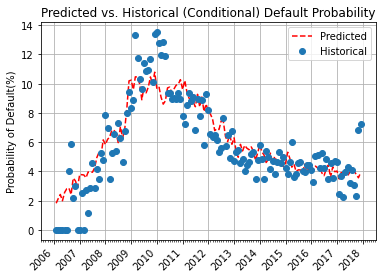

In [ ]:
import matplotlib.pyplot as plt

#plot
fig = plt.figure()
from matplotlib.dates import DateFormatter, YearLocator,MonthLocator
years = YearLocator()        # major ticks on the years
months = MonthLocator()              # minor ticks on the months
yearFormatter = DateFormatter('%Y')  # e.g.,  12
monthFormatter = DateFormatter('%m')      # e.g., 12
fig = plt.figure(1)
# plot the P(DF) for DEL Dataset
ax = fig.add_subplot(1,1,1)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_formatter(yearFormatter)
ax.xaxis_date()
ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Probability of Default(%)')
plt.title('Predicted vs. Historical (Conditional) Default Probability')
plt.plot(pred_table.index,pred_table['DF'],'r--',label='Predicted')
# plt.hist(test.index,test['P(DF)'], bins = 10)
plt.plot(test.index,test['P(DF)'],'o',label='Historical')  # it's better to use histogram 
plt.grid()
plt.legend()
plt.show()